Rebeca Padovani Ederli

RA: 201482


Este notebook foi baseado no notebook apresentado em aula dos estudos de Deep Learning. 

## Importação de bibliotecas

In [2]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix
plt.ion() 

from google.colab import drive
drive.mount('/content/gdrive')

!ls '/content/gdrive/MyDrive/Data_P4_DL/'

Mounted at /content/gdrive
231900_263013_ATOM.txt	test  test-1  train  val


## Carregando os dados e aplicando *data augmentation*.


In [39]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=(0.5, 1.2),contrast=(0.8,1.2)),
        transforms.RandomAdjustSharpness(2),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=(0.5, 1.2),contrast=(0.8,1.2)),
        transforms.RandomAdjustSharpness(2),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.Normalize(0, 1)
    ]),
}

data_dir = '/content/gdrive/MyDrive/Data_P4_DL/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualizando algumas imagens (one batch)

Batch of training data


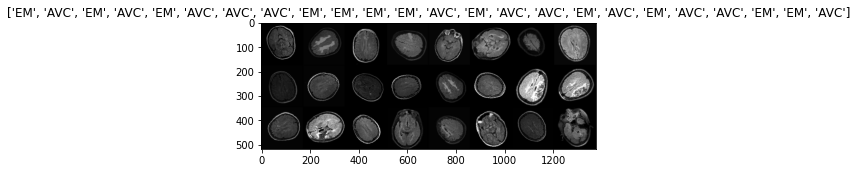

min =  0.0
median =  0.023529412
mean =  0.13174838
max =  1.0
Batch of validation data


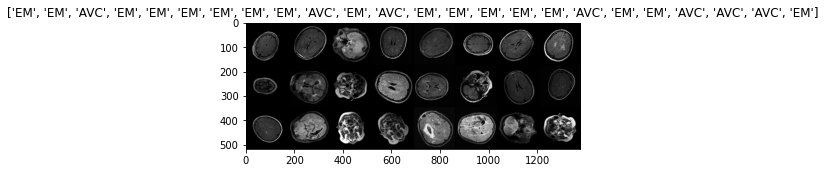

min =  0.0
median =  0.011764706
mean =  0.1257942
max =  1.0
Batch of test data


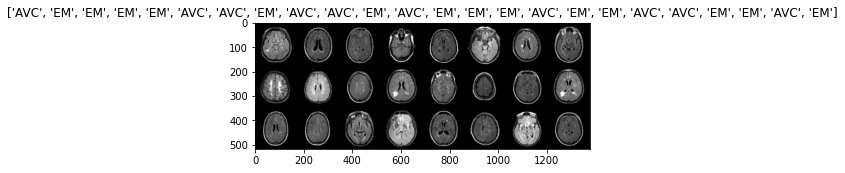

min =  0.0
median =  0.003921569
mean =  0.16731699
max =  0.99607843


In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

## Treinamento

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Definindo parâmetros de treinamento. Foi escolhida a arquitetura ResNet18 não pré-treinada.

In [ ]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

In [ ]:
summary(model, (3, 170, 170))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

##Realizando o treinamento

###Sem normalização, com *data augmentation*.

O primeiro treinamento utiliza 100 épocas para que o efeito de overfitting possa ser visualizado em uma média de 10 iterações.

Os tamanhos dos conjuntos de dados são respectivamente:

In [44]:
print("Conjunto de treinamento: ", dataset_sizes['train'])
print("Conjunto de validação: ", dataset_sizes['val'])
print("Conjunto de teste: ", dataset_sizes['test'])

Conjunto de treinamento:  507
Conjunto de validação:  182
Conjunto de teste:  78


In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 
  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=100)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 4/99
----------
train Loss: 0.6317 Acc: 0.6824
val Loss: 0.6293 Acc: 0.7088

Epoch 5/99
----------
train Loss: 0.6252 Acc: 0.7298
val Loss: 0.5959 Acc: 0.7363

Epoch 6/99
----------
train Loss: 0.6131 Acc: 0.7377
val Loss: 0.6078 Acc: 0.7912

Epoch 7/99
----------
train Loss: 0.6180 Acc: 0.7396
val Loss: 0.5804 Acc: 0.7967

Epoch 8/99
----------
train Loss: 0.5997 Acc: 0.7535
val Loss: 0.5703 Acc: 0.8077

Epoch 9/99
----------
train Loss: 0.5944 Acc: 0.7830
val Loss: 0.5752 Acc: 0.8132

Epoch 10/99
----------
train Loss: 0.5718 Acc: 0.8462
val Loss: 0.5446 Acc: 0.8462

Epoch 11/99
----------
train Loss: 0.5600 Acc: 0.8245
val Loss: 0.5404 Acc: 0.8407

Epoch 12/99
----------
train Loss: 0.5503 Acc: 0.8264
val Loss: 0.5266 Acc: 0.8187

Epoch 13/99
----------
train Loss: 0.5396 Acc: 0.7929
val Loss: 0.5035 Acc: 0.8132

Epoch 14/99
----------
train Loss: 0.5192 Acc: 0.8422
val Loss: 0.5353 Acc: 0.8571

Epoch 15/99
----------


In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []

for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])
    
  ACC_train_mean.append(np.mean(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))

Por meio do gráfio **acurácias do treinamento e validação x época**, é possível observar que o overfitting ocorre a partir da 40ª época.

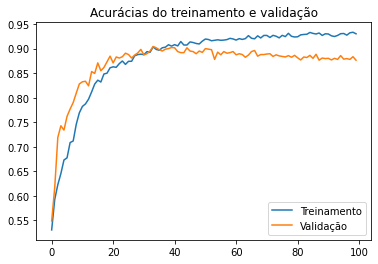

In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

Ao observarmos o gráfico **loss de treinamento e validação x época**, nota-se que apartir da 40ª época, *loss* para de diminuir sob o conjunto de validação. 

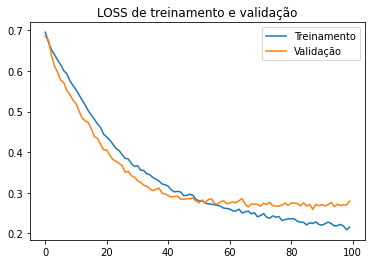

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

Nesse sentido, o segundo treinamento consiste em fazer com que o classificador pare na 40ª época.

In [ ]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 
  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=40)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

Epoch 0/39
----------
train Loss: 0.6944 Acc: 0.5562
val Loss: 0.6760 Acc: 0.6484

Epoch 1/39
----------
train Loss: 0.6637 Acc: 0.6844
val Loss: 0.6455 Acc: 0.7473

Epoch 2/39
----------
train Loss: 0.6383 Acc: 0.6943
val Loss: 0.6323 Acc: 0.7473

Epoch 3/39
----------
train Loss: 0.6236 Acc: 0.6963
val Loss: 0.6157 Acc: 0.7253

Epoch 4/39
----------
train Loss: 0.6131 Acc: 0.7101
val Loss: 0.5796 Acc: 0.7857

Epoch 5/39
----------
train Loss: 0.6004 Acc: 0.7061
val Loss: 0.5579 Acc: 0.7637

Epoch 6/39
----------
train Loss: 0.5873 Acc: 0.7061
val Loss: 0.5414 Acc: 0.7912

Epoch 7/39
----------
train Loss: 0.5672 Acc: 0.7475
val Loss: 0.5623 Acc: 0.7637

Epoch 8/39
----------
train Loss: 0.5614 Acc: 0.7318
val Loss: 0.5542 Acc: 0.7582

Epoch 9/39
----------
train Loss: 0.5496 Acc: 0.7337
val Loss: 0.5433 Acc: 0.7747

Epoch 10/39
----------
train Loss: 0.5509 Acc: 0.7633
val Loss: 0.5074 Acc: 0.8187

Epoch 11/39
----------
train Loss: 0.5316 Acc: 0.7396
val Loss: 0.4751 Acc: 0.8352

Ep

In [ ]:
ACC_train_mean = []
ACC_val_mean = []
LOSS_train_mean = []
LOSS_val_mean = []

for i in range(len(ACC_train_it[0])):
  ACC_train_ep = []
  ACC_val_ep = []
  LOSS_train_ep = []
  LOSS_val_ep = []
  for j in range(len(ACC_train_it)):
    ACC_train_ep.append(ACC_train_it[j][i].item())
    ACC_val_ep.append(ACC_val_it[j][i].item())
    LOSS_train_ep.append(LOSS_train_it[j][i])
    LOSS_val_ep.append(LOSS_val_it[j][i])

  ACC_train_mean.append(np.mean(ACC_train_ep))
  ACC_val_mean.append(np.mean(ACC_val_ep))
  LOSS_train_mean.append(np.mean(LOSS_train_ep))
  LOSS_val_mean.append(np.mean(LOSS_val_ep))

Ao treinar o classificador por 40 épocas, o efeito de overfitting é mitigado.

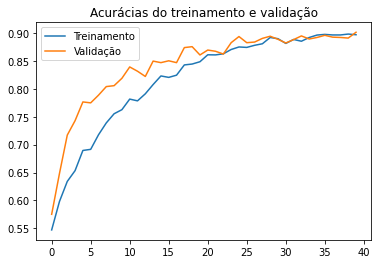

In [ ]:
plt.plot(ACC_train_mean, label="Treinamento")
plt.plot(ACC_val_mean, label="Validação")
plt.title("Acurácias do treinamento e validação")
plt.legend()
plt.show()

Com apenas 40 épocas, a função **loss** ainda está em queda, como pode-se observar no gráfico abaixo.

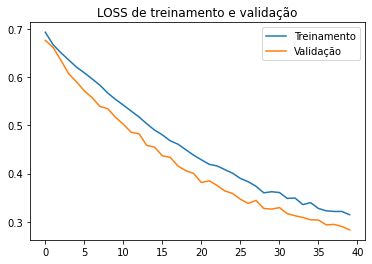

In [ ]:
plt.plot(LOSS_train_mean, label = "Treinamento")
plt.plot(LOSS_val_mean, label="Validação")
plt.title("LOSS de treinamento e validação")
plt.legend()
plt.show()

In [12]:
LOSS_train_it = []
LOSS_val_it = []
ACC_train_it = []
ACC_val_it = []

for i in range(10):
  LOSS_train = []
  LOSS_val = []
  ACC_train = []
  ACC_val = []
  model = models.resnet18(pretrained=False)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 2)
  model = model.to(device) 
  criterion = nn.CrossEntropyLoss()
  optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)
  model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=40)
  LOSS_train_it.append(LOSS_train)
  LOSS_val_it.append(LOSS_val)
  ACC_train_it.append(ACC_train)
  ACC_val_it.append(ACC_val)

Epoch 0/39
----------
train Loss: 0.7188 Acc: 0.4556
val Loss: 0.6786 Acc: 0.6758

Epoch 1/39
----------
train Loss: 0.6859 Acc: 0.5523
val Loss: 0.6505 Acc: 0.6484

Epoch 2/39
----------
train Loss: 0.6746 Acc: 0.5582
val Loss: 0.6380 Acc: 0.6703

Epoch 3/39
----------
train Loss: 0.6654 Acc: 0.6016
val Loss: 0.6380 Acc: 0.6758

Epoch 4/39
----------
train Loss: 0.6534 Acc: 0.6075
val Loss: 0.6200 Acc: 0.6593

Epoch 5/39
----------
train Loss: 0.6451 Acc: 0.5937
val Loss: 0.6132 Acc: 0.7253

Epoch 6/39
----------
train Loss: 0.6334 Acc: 0.6529
val Loss: 0.6058 Acc: 0.7253

Epoch 7/39
----------
train Loss: 0.6320 Acc: 0.7278
val Loss: 0.6032 Acc: 0.7967

Epoch 8/39
----------
train Loss: 0.6113 Acc: 0.7278
val Loss: 0.5841 Acc: 0.7308

Epoch 9/39
----------
train Loss: 0.6086 Acc: 0.6746
val Loss: 0.5529 Acc: 0.7802

Epoch 10/39
----------
train Loss: 0.5987 Acc: 0.6903
val Loss: 0.5714 Acc: 0.8736

Epoch 11/39
----------
train Loss: 0.5846 Acc: 0.7830
val Loss: 0.5567 Acc: 0.8736

Ep

##Visualização das predições do modelo para o conjunto de teste estabelecido.

In [10]:
def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()
              if images_so_far == num_images:
                model.train(mode=was_training)
                return PREDICTED, LABEL
        model.train(mode=was_training)

    return PREDICTED, LABEL

In [13]:
test_group_len = 78
PREDICTED, LABEL = predic_model(model, plot_img = False, num_images=test_group_len)

O modelo treinado atingiu acurácia de 100% sob o conjunto de teste estabelecido.

In [14]:
test_AVC_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'AVC'])
test_EM_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'EM'])

print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_EM_size 
Especificidade = CM_test[0,0]/test_AVC_size 
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)



 Conjunto de Teste 

labels =  ['EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'AVC']
predições =  ['EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM

É possível observar que mesmo o modelo não chegando a 100% de acurácia durante o treinamento e validação, ao ser testado em um conjunto nunca visto antes pelo classificador, as predições foram 100% coerentes com as labels.

Predizendo de um grupo menor, apenas 25 imagens, para visualização.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


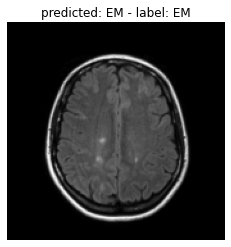

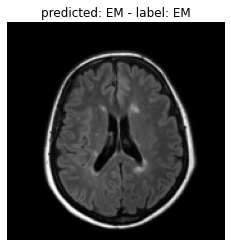

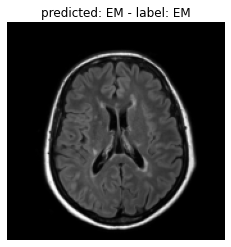

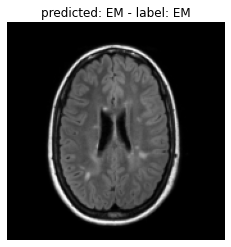

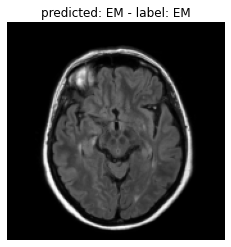

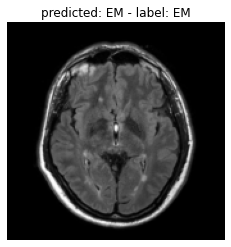

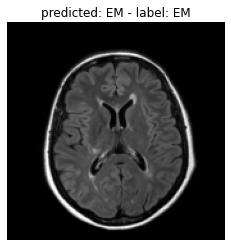

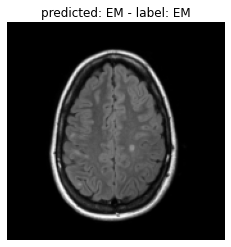

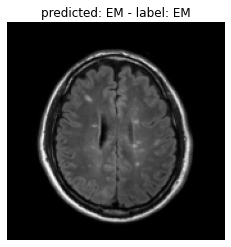

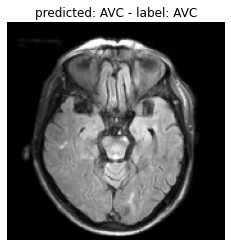

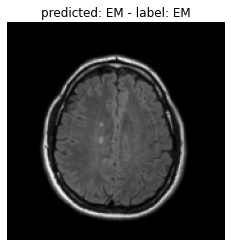

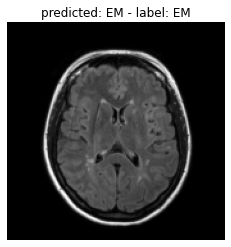

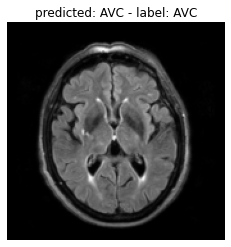

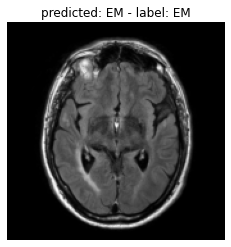

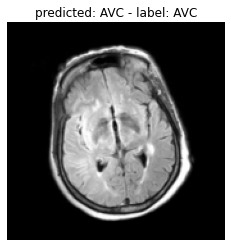

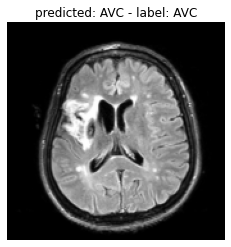

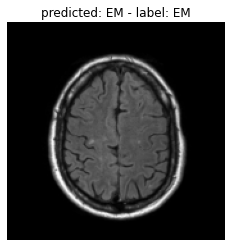

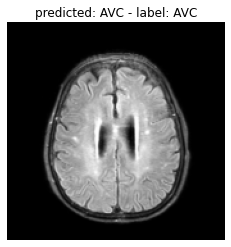

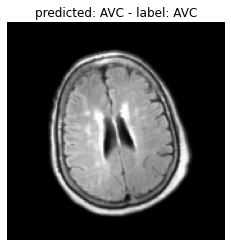

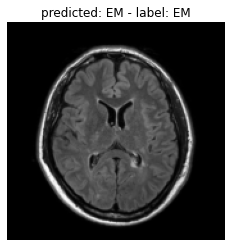

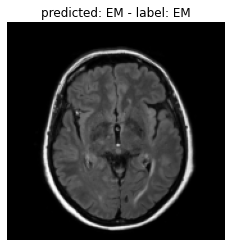

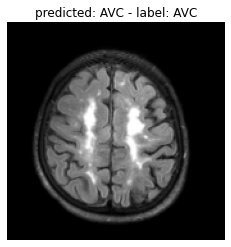

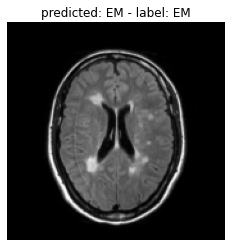

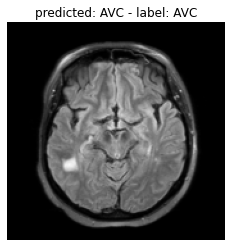

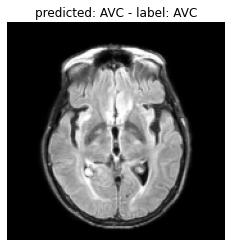

In [40]:
test_group_len = 25
PREDICTED, LABEL = predic_model(model, plot_img = True, num_images=test_group_len)

In [42]:
test_AVC_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'AVC'])
test_EM_size = len([x for x in range(len(LABEL)) if LABEL[x] == 'EM'])

print('\n Conjunto de Teste Menor (25 imagens) \n')
CM_test = confusion_matrix(LABEL, PREDICTED)
Sensibilidade = CM_test[1,1]/test_EM_size # Sensibilidade: é a razão entre as imagens com EM classificadas corretamente e o total de imagens com EM (Verdadeiros positivos ÷ EM)
Especificidade = CM_test[0,0]/test_AVC_size # Especificidade: é a razão entre as imagens com AVC classificadas corretamente e o total de imagens com AVC (Verdadeiros negativos ÷ AVC)
print('labels = ', LABEL)
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(LABEL)) if LABEL[x] == PREDICTED[x]])/test_group_len)



 Conjunto de Teste Menor (25 imagens) 

labels =  ['EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'AVC']
predições =  ['EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'AVC']
matriz de confusão = 
 [[ 9  0]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  1.0
acc =  1.0


##Resultado para o conjunto de teste da atividade apresentada em aula.

Leitura do conjunto de teste apresentado em aula.

In [46]:
data_transforms = {
    'test-atividade': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
}

data_dir = '/content/gdrive/MyDrive/Data_P4_DL/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test-atividade']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=False, num_workers=2) for x in ['test-atividade']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test-atividade']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Lendo o arquivo com as labels de um grupo que chegou a 100% de acurácia na atividade com classificador SVM e estabelencendo as predições como LABELS.

In [24]:
import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/Data_P4_DL/labels-test-atividade.txt', sep=" ", header=None)

In [31]:
LABEL = data[1]

In [33]:
def predic_model_atividade(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test-atividade']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()
              if images_so_far == num_images:
                model.train(mode=was_training)
                return PREDICTED, LABEL
        model.train(mode=was_training)

    return PREDICTED, LABEL

Realizando as predições sob o novo conjunto de teste e obtendo métricas dos resultados.

O tamanho do conjunto de teste apresentado para a atividade é:

In [47]:
print("Conjunto de teste da atividade: ", dataset_sizes['test-atividade'])

Conjunto de teste da atividade:  225


In [34]:
test_group_len = dataset_sizes['test-atividade']
PREDICTED, LABEL = predic_model_atividade(model, plot_img = False, num_images=test_group_len)

In [38]:
test_AVC_size = len([x for x in range(len(data[1])) if data[1][x] == 'AVC'])
test_EM_size = len([x for x in range(len(data[1])) if data[1][x] == 'EM'])
print('\n Conjunto de Teste \n')
CM_test = confusion_matrix(data[1], PREDICTED)
Sensibilidade = CM_test[1,1]/test_EM_size 
Especificidade = CM_test[0,0]/test_AVC_size

print('labels = ', data[1])
print('predições = ', PREDICTED)
print('matriz de confusão = \n', CM_test)
print('Sensibilidade = ', Sensibilidade)
print('Especificidade = ', Especificidade)
print('acc = ', len([x for x in range(len(data[1])) if data[1][x] == PREDICTED[x]])/test_group_len)


 Conjunto de Teste 

labels =  0      AVC
1       EM
2      AVC
3       EM
4       EM
      ... 
220     EM
221    AVC
222    AVC
223     EM
224     EM
Name: 1, Length: 225, dtype: object
predições =  ['AVC', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'EM', 'AVC', 'EM', 'AVC', 'AVC', 'EM', 'AVC', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'EM', 'AV

O modelo também atingiu 100% de acurácia para o conjunto de teste apresentado na atividade da disciplina. É possível concluir que o modelo consegue classificar as imagens de conjuntos não vistos antes (generalização). 

##Predição com o conjunto SLE.

In [79]:
data_transforms = {
    'SLE': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
}

data_dir = '/content/gdrive/MyDrive/Data_P4_DL/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['SLE']}

##Removendo as máscaras
print(len(image_datasets['SLE'].imgs))
for img in image_datasets['SLE'].imgs:
  if img[0][-8:] == 'mask.png':
    image_datasets['SLE'].imgs.remove((img))
print(len(image_datasets['SLE'].imgs))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=False) for x in ['SLE']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['SLE']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1394
697


device(type='cuda', index=0)

In [80]:
dataset_sizes['SLE']

697

In [82]:
def predic_model_SLE(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['SLE']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()
              if images_so_far == num_images:
                model.train(mode=was_training)
                return PREDICTED, LABEL
        model.train(mode=was_training)

    return PREDICTED, LABEL

In [83]:
test_group_len = dataset_sizes['SLE']
PREDICTED, LABEL = predic_model_SLE(model, plot_img = False, num_images=test_group_len)

In [102]:

print('\n Conjunto de Teste SLE\n')
print('predições = ', PREDICTED)



 Conjunto de Teste SLE

predições =  ['AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'EM', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AV

In [110]:
PREDICTED[97]

'EM'

In [107]:
PREDICTED_avc = []
PREDICTED_em = []
for x in range(len(PREDICTED)):
  if PREDICTED[x] == 'AVC':
    PREDICTED_avc.append(PREDICTED[x])
  elif PREDICTED[x] == 'EM':
    PREDICTED_em.append(PREDICTED[x])
    print(x)

97


In [108]:
print("Classificação 'AVC': ", len(PREDICTED_avc))
print("Classificação 'EM': ", len(PREDICTED_em))

Classificação 'AVC':  696
Classificação 'EM':  1


In [109]:
image_datasets['SLE'].imgs[97]

('/content/gdrive/MyDrive/Data_P4_DL/SLE/SLE/610_FLAIR26.png', 0)